Давайте подивимося, як LSTM можна використовувати для побудови нейронної мережі прогнозування часових.

Будемо працювати з задачею прогнозування кількості пасажирів міжнародних авіаліній. З цим набором даних ми вже працювали в лекції "Time Series Analysis" і ви зможете порівняти результати :)

Задача полягає в тому, щоб за заданими роком і місяцем передбачити кількість пасажирів міжнародних авіаліній в одиницях виміру 1,000. Дані охоплюють період з січня 1949 року по грудень 1960 року, тобто 12 років, зі 144 спостереженнями.

Це регресійна задача. Тобто, знаючи кількість пасажирів (в тисячах) за останні місяці, можна передбачити, якою буде кількість пасажирів у наступному місяці. Набір даних має лише одну характеристику: "Кількість пасажирів" - `Passengers`.

Далі вже наведений код для читання даних, але нам їх ще треба буде трошки обробити.

In [138]:
!pip install torch

In [139]:
pip install scikit-learn scipy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [140]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import root_mean_squared_error
from  matplotlib import pyplot as plt

In [141]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Завантаження даних
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.set_index('Month', inplace=True)
display(df.head())

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


**Завдання 1.** Створіть змінну типу `numpy.ndarray`, яка містить значення кількості пасажирів в форматі `float32`. Такий формат даних нам треба для тренування нейромережі.

In [142]:
passengers = df.Passengers.astype('float32').to_numpy()
print(passengers)

[112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
 141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.
 172. 178. 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218.
 230. 242. 209. 191. 172. 194. 196. 196. 236. 235. 229. 243. 264. 272.
 237. 211. 180. 201. 204. 188. 235. 227. 234. 264. 302. 293. 259. 229.
 203. 229. 242. 233. 267. 269. 270. 315. 364. 347. 312. 274. 237. 278.
 284. 277. 317. 313. 318. 374. 413. 405. 355. 306. 271. 306. 315. 301.
 356. 348. 355. 422. 465. 467. 404. 347. 305. 336. 340. 318. 362. 348.
 363. 435. 491. 505. 404. 359. 310. 337. 360. 342. 406. 396. 420. 472.
 548. 559. 463. 407. 362. 405. 417. 391. 419. 461. 472. 535. 622. 606.
 508. 461. 390. 432.]


Очікуваний результат:
```array([112., 118., 132., 129., 121.], dtype=float32)```

**Завдання 2**. Розбийте дані на тренувальні і валідаційні у співвідношенні 67% йде у тренування, 33 - у валідацію. Памʼятаємо, що ми працюємо з tim series, відповідно, навчаємось на давніших, валідуємось - на новіших.

In [143]:
train_count = int(round(len(passengers)*0.67, 0))


In [144]:
train = passengers[:train_count]
test = passengers[train_count:]

In [145]:
len(train), len(test)

(96, 48)

**Завдання 3**.

Реалізуйте функцію `create_dataset`, яка перетворить одномірний часовий ряд (набір даних) у формат, придатний для тренування нейромережі.

Функція повинна приймати два аргументи:
- `dataset` — numpy-масив часового ряду,
- `lookback` — кількість попередніх кроків, які використовуватимуться для передбачення.

Функція повинна повернути два **тензори** PyTorch:
- `X` — набір ознак (вікно попередніх значень),
- `y` — цільові значення (наступні після вікна кроки).

Дані ми будемо подавати моделі в наступному форматі:
`
tensor([[112.],
        [118.],
        [132.],
        [129.],
        [121.]])
`
Відповідно першою розмірністю буде йти розмір вхідного батча, а другою - розмір вхіднизх даних і в нас це 1, бо лише одне значення на вході щоразу.

Після виконання завдання запустіть код нижче. Ми будемо передбачати на основі кількості пасажирів в попередній день кількість пасажирів в наступний, тому `lookback == 1`.

In [146]:
def create_dataset(dataset, lookback = 1):
    # Initialize lists to hold the input sequences (X) and target values (y)
    X, y = [], []
    
    # Loop over the dataset and create input sequences and corresponding targets
    for i in range(len(dataset) - lookback):
        X.append(dataset[i:(i + lookback)])
        y.append(dataset[(i + lookback):(i + lookback + 1)])
    
    # Convert X and y to PyTorch tensors
    X = torch.tensor(np.array(X), dtype=torch.float32)
    y = torch.tensor(np.array(y), dtype=torch.float32)
    
    return X, y

In [147]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])


Очікуваний результат:
```
torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])
```

**Завдання 4**.

Зверніть увагу на розмірності в попередньому завданні. Ми
З допомогою модуля `torch.nn` опишіть клас `AirModel`, який є нейронною мережею для прогнозування кількості пасажирів за допомогою LSTM.

1. **Конструктор класу** повинен приймати параметри `hidden_size`, `num_layers` та ініціювати шари:
   - LSTM-шар з наступними параметрами:
     - `input_size` — кожна точка часового ряду є окремим входом,,
     - `hidden_size` — заданий в конструкторі класу мережі,
     - `num_layers=1` — кількість шарів LSTM, задана в конструкторі мережі,
     - `batch_first=True` — визначає, що першим виміром є розмір батчу.
   - Лінійний шар (`nn.Linear`) для перетворення виходу LSTM на прогноз однієї точки.

2. **Метод forward** повинен виконувати наступні дії:
   - Передати вхідний тензор через LSTM-шар і отримати виходи (ігноруючи приховані стани).
   - Пропустити вихід LSTM через лінійний шар для отримання остаточного прогнозу.

Створіть об'єкт класу `AirModel` зі значеннями параметрів `hidden_size=50`, `num_layers=1` і протестуйте роботу моделі на вхідному тензорі `tensor([[112.]])`. На цьому етапі ми маємо переконатись, що модель здатна генерувати передбачення з рандомно ініційованими вагами.

In [148]:
class AirModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(AirModel, self).__init__()
        self.hidden_dim = hidden_size
        self.layer_dim = num_layers
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.fc = torch.nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

In [149]:
air_model = AirModel(1, 50, 1)
test_data = torch.tensor(np.array([112]), dtype=torch.float32).unsqueeze(1)
test_data

tensor([[112.]])

In [150]:
air_model(test_data)

tensor([[-0.1295]], grad_fn=<AddmmBackward0>)

**Завдання 5**.

Створіть об'єкт DataLoader для завантаження даних, використовуючи тренувальні вибірки `X_train` та `y_train`. Ваш DataLoader повинен виконувати наступні вимоги:

1. Використовувати клас `TensorDataset`, щоб об'єднати тензори ознак `X_train` і цільових значень `y_train`.
2. Дані повинні завантажуватися невеликими батчами розміром 8 за допомогою параметра `batch_size`.
3. Використовувати параметр `shuffle=True`, щоб дані перемішувалися перед кожною епохою тренування.


In [151]:
train_ds = TensorDataset(X_train, y_train)
data_loader = DataLoader(dataset=train_ds, batch_size=8, shuffle=True)
test_ds = TensorDataset(X_test, y_test)
data_loader_test = DataLoader(dataset=test_ds, batch_size=8, shuffle=True)

In [152]:
next(iter(data_loader))

[tensor([[229.],
         [170.],
         [317.],
         [203.],
         [135.],
         [274.],
         [374.],
         [235.]]),
 tensor([[203.],
         [170.],
         [313.],
         [229.],
         [148.],
         [237.],
         [413.],
         [227.]])]

**Завдання 6**.

1. Реалізуйте навчання нейронної мережі `AirModel` для прогнозування часових рядів, використовуючи Adam-оптимізатор та функцію втрат MSE (середньоквадратичну похибку).
2. Створіть цикл тренування для 2000 епох, у якому на кожній епосі:
   - Виконуйте крок тренування моделі (прямий прохід, обчислення похибки, зворотний прохід і оновлення ваг).
   - Підраховуйте середню похибку на кожному батчі даних і зберігайте її у списку `losses`.
3. Раз на 100 епох проводьте валідацію моделі:
   - Перевіряйте модель на тренувальних та тестових даних без оновлення ваг.
   - Обчислюйте корінь середньоквадратичної похибки (RMSE) для тренувальної та тестової вибірок і виводьте результати на екран.
   
**Примітка:**
- Використовуйте вже створений `DataLoader` для отримання батчів даних.
- Валідацію виконуйте в режимі `eval()`, вимикаючи обчислення градієнтів з `torch.no_grad()`.

**Приклад виходу:**
```
Epoch 0: train RMSE 12.3456, test RMSE 15.6789
Epoch 100: train RMSE 9.8765, test RMSE 12.3456
...
```

In [153]:
optimizer = torch.optim.Adam(air_model.parameters(), lr=0.01)
loss_fn = F.mse_loss

In [154]:
def train(model, data_loader, optimizer, loss_fn):
    lossSum = 0
    for X, y in data_loader:
        optimizer.zero_grad()
        output = model(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        lossSum += loss.item()
    return lossSum/len(data_loader)
    
def validate(model, data_loader):
    lossSum = 0
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            loss = root_mean_squared_error(output, y)
            lossSum += loss
    return lossSum/len(data_loader)

In [155]:
num_epochs = 2000
losses = []
for i in range(num_epochs):   
    air_model.train()
    mse = train(air_model, data_loader, optimizer, loss_fn)
    losses.append(mse)
    if i % 100 == 0:
        air_model.eval()
        rmse_train = validate(air_model, data_loader)
        rmse_test = validate(air_model, data_loader_test)
        print(f'Epoch {i}: train RMSE {rmse_train}, test RMSE {rmse_test}')
    

Epoch 0: train RMSE 221.69170761108398, test RMSE 418.52490234375
Epoch 100: train RMSE 48.77292092641195, test RMSE 198.49339294433594
Epoch 200: train RMSE 43.42183335622152, test RMSE 171.91290283203125
Epoch 300: train RMSE 36.53908618291219, test RMSE 157.2401377360026
Epoch 400: train RMSE 38.87797101338705, test RMSE 145.8138542175293
Epoch 500: train RMSE 37.62205378214518, test RMSE 147.48418680826822
Epoch 600: train RMSE 35.1569390296936, test RMSE 141.60072580973306
Epoch 700: train RMSE 35.240143616994224, test RMSE 137.78111012776694
Epoch 800: train RMSE 35.61797173817953, test RMSE 137.9154256184896
Epoch 900: train RMSE 35.14783795674642, test RMSE 140.58971786499023
Epoch 1000: train RMSE 36.48209730784098, test RMSE 141.3282699584961
Epoch 1100: train RMSE 37.65431992212931, test RMSE 139.00487899780273
Epoch 1200: train RMSE 32.06494720776876, test RMSE 138.4446004231771
Epoch 1300: train RMSE 30.096516847610474, test RMSE 136.9911321004232
Epoch 1400: train RMSE 34

**Завдання 7.** Побудуйте графік лосів. Зробіть висновок з графіку, чи навчилась модель?

In [156]:
air_model.eval()
t = air_model(X_train[0:5])

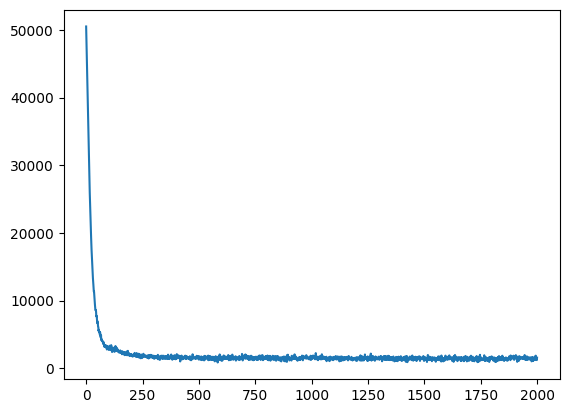

In [157]:
plt.plot(losses)

Модель навчилась, але не факт, що точно)

Доволі неочікувано, що середньоквадратичне відхилення тестового набору даних буде на порядок більшим за одиниці в нашому наборі даних. Середньоквадратичне відхилення 100 означає, що прогноз і фактичне значення будуть відрізнятися в середньому на 100 (тобто, 100 000 пасажирів у цьому наборі даних).



Щоб краще зрозуміти якість прогнозу, ви можете побудувати графік з кодом нижче (а ще нижче - описано, що відбувається в цьому коді, бо це теж корисно зрозуміти):

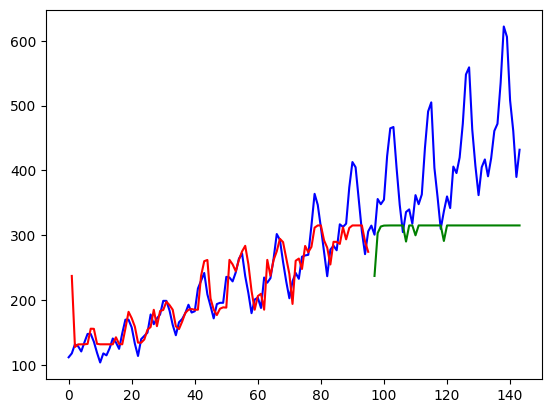

In [184]:
timeseries = torch.tensor(np.array(passengers), dtype=torch.float32)
def plot_predicts(air_model):
  with torch.no_grad():
      # Зсув прогнозів для тренувальних даних
      train_plot = np.ones_like(timeseries) * np.nan
      y_pred = air_model(X_train)
      y_pred = y_pred[:, -1]
      train_plot[lookback:train_count] = air_model(X_train)[:, -1]

      # Зсув прогнозів для тестових даних
      test_plot = np.ones_like(timeseries) * np.nan
      test_plot[train_count+lookback:len(timeseries)] = air_model(X_test)[:, -1]

  # Візуалізація результатів
  plt.plot(timeseries, c='b')  # Реальні дані
  plt.plot(train_plot, c='r')  # Прогнози на тренувальних даних
  plt.plot(test_plot, c='g')   # Прогнози на тестових даних
  plt.show()

plot_predicts(air_model)

**Що відбувається в коді вище.** В цьому коді здійснюється процес прогнозування часових рядів за допомогою LSTM моделі, а також виведення графіку, який показує реальні значення, тренувальні та тестові прогнози. Ось що відбувається на кожному етапі:

1. **`torch.no_grad()`**: Цей контекстний менеджер вимикає обчислення градієнтів, що означає, що під час прогнозування не будуть зберігатися проміжні обчислення для зворотного проходу (backpropagation). Це підвищує ефективність під час прогнозування і зменшує використання пам'яті.

2. **Зсув прогнозів для тренувальних даних:**
   - Створюється масив `train_plot`, який має такий самий розмір, як і часовий ряд (`timeseries`), і заповнюється значеннями NaN (`np.nan`), щоб залишити місце для реальних значень.
   - Модель передбачає виходи для тренувальних даних `X_train`.
   - Використовується лише останнє передбачене значення для кожного входу LSTM (`y_pred[:, -1]`).
   - Прогнози зсуваються, починаючи з індексу `lookback` до кінця тренувальних даних (індекс `train_size`). Цей зсув потрібен, щоб зробити прогноз на основі попередніх даних і відобразити його на правильній частині графіку.

3. **Зсув прогнозів для тестових даних:**
   - Створюється масив `test_plot`, який також заповнюється NaN.
   - Прогнози для тестових даних додаються з індексу `train_size + lookback` до кінця реальних даних, щоб відобразити, де модель починає прогнозувати тестову вибірку.

4. **Побудова графіка:**
   - `plt.plot(timeseries, c='b')`: Виводить реальні значення часового ряду (синя лінія).
   - `plt.plot(train_plot, c='r')`: Виводить тренувальні прогнози (червона лінія).
   - `plt.plot(test_plot, c='g')`: Виводить тестові прогнози (зелена лінія).

**Чому це робиться:**
- Зсув прогнозів для тренувальних і тестових даних дозволяє візуально зрівняти, наскільки добре модель прогнозує як на тренувальній, так і на тестовій вибірках. Зазвичай, червона лінія (тренувальні прогнози) повинна точно відповідати синій лінії (реальні дані), а зелена лінія (тестові прогнози) дає змогу побачити, наскільки модель добре працює на нових даних, яких вона раніше не бачила.

**Завдання 8**. Навчіть модель з hidden_size=100 та порівняйте результати прогнозів з попередніми.

In [187]:
air_model_100 = AirModel(1, 100, 1)
num_epochs = 20000
losses_100 = []
optimizer_100 = torch.optim.Adam(air_model_100.parameters(), lr=0.001)
loss_fn_100 = F.mse_loss
for i in range(num_epochs):   
    air_model_100.train()
    mse = train(air_model_100, data_loader, optimizer_100, loss_fn_100)
    losses_100.append(mse)
    if i % 100 == 0:
        air_model_100.eval()
        rmse_train = validate(air_model_100, data_loader)
        rmse_test = validate(air_model_100, data_loader_test)
        print(f'Epoch {i}: train RMSE {rmse_train}, test RMSE {rmse_test}')

Epoch 0: train RMSE 223.7311045328776, test RMSE 421.2432810465495
Epoch 100: train RMSE 129.5364195505778, test RMSE 320.61753845214844
Epoch 200: train RMSE 81.47891934712727, test RMSE 258.0355707804362
Epoch 300: train RMSE 53.13930622736613, test RMSE 213.06550089518228
Epoch 400: train RMSE 38.30603233973185, test RMSE 174.76590855916342
Epoch 500: train RMSE 30.823407014211018, test RMSE 149.7992909749349
Epoch 600: train RMSE 30.213605880737305, test RMSE 132.80658976236978
Epoch 700: train RMSE 26.495956420898438, test RMSE 117.06655248006184
Epoch 800: train RMSE 27.370306968688965, test RMSE 103.38963572184245
Epoch 900: train RMSE 22.356247425079346, test RMSE 99.8311996459961
Epoch 1000: train RMSE 22.511658827463787, test RMSE 85.00835100809734
Epoch 1100: train RMSE 22.81612428029378, test RMSE 84.44242159525554
Epoch 1200: train RMSE 22.446134328842163, test RMSE 90.7138188680013
Epoch 1300: train RMSE 23.703535556793213, test RMSE 82.05798467000325
Epoch 1400: train RM

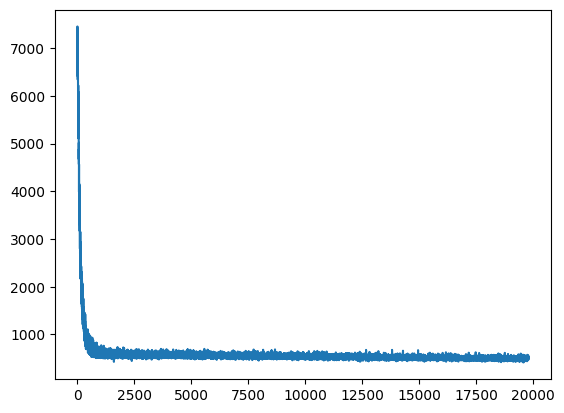

In [195]:
plt.plot(losses_100[200:])

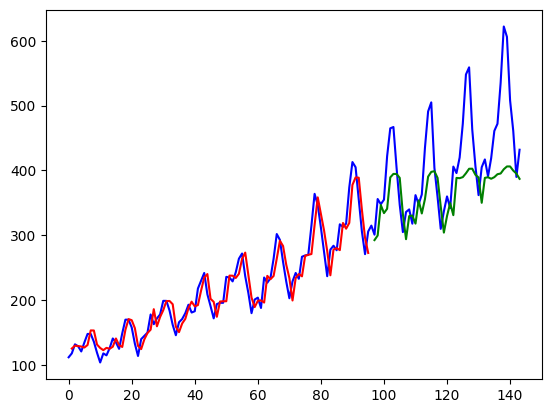

In [196]:
plot_predicts(air_model_100)

Збільшивши кількість епох навчання і зменшивши learning rate вдалося досягнути деякого покарщення результатів